In [1]:
import pyspark

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
conf = spark.sparkContext._conf.setAll([
    ("hive.metastore.uris", "thrift://elephant:9083")])

In [4]:
spark.sparkContext.stop()

In [5]:
spark = SparkSession.builder.config(conf=conf).getOrCreate()

In [6]:
df = spark.sql("select * from refined.chuvas_vazoes") \
     .withColumn("volume_vazao", regexp_replace(col("volume_vazao"), ",", ".").cast("float")) \
     .withColumn("volume_chuva", regexp_replace(col("volume_chuva"), ",", ".").cast("float")) \
     .withColumn("data", to_date("data", "dd/MM/yyyy")) \
     .withColumn("flag_ong", when(col("data") > "2005-12-31",1).otherwise(0)) \
     .distinct()

In [7]:
df.show()

+----------+------------+------------+--------+--------+----------------------+
|      data|volume_chuva|volume_vazao|floresta|flag_ong|data_inclusao_registro|
+----------+------------+------------+--------+--------+----------------------+
|1996-03-02|         0.0|       3.267|27700000|       0|            2019-06-04|
|1993-03-04|        14.2|       6.809|28550000|       0|            2019-06-04|
|1995-04-04|         0.0|       5.026|28550000|       0|            2019-06-04|
|2004-10-04|        21.8|       2.631|25030000|       0|            2019-06-04|
|1996-04-05|         0.0|       3.435|27700000|       0|            2019-06-04|
|2008-04-05|        11.4|       5.458|25030000|       1|            2019-06-04|
|1997-07-08|         0.0|       2.266|27700000|       0|            2019-06-04|
|2011-03-09|         2.7|       7.668|25030000|       1|            2019-06-04|
|2007-02-10|         0.0|       5.908|25030000|       1|            2019-06-04|
|1998-01-11|         0.0|       2.631|27

In [8]:
df.printSchema()

root
 |-- data: date (nullable = true)
 |-- volume_chuva: float (nullable = true)
 |-- volume_vazao: float (nullable = true)
 |-- floresta: long (nullable = true)
 |-- flag_ong: integer (nullable = false)
 |-- data_inclusao_registro: date (nullable = true)



# Train Test Split and Linear Regression

In [9]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

In [10]:
df.write.mode("overwrite").parquet("./teste.parquet")

In [11]:
df = spark.read.parquet("./teste.parquet")

In [12]:
assembler = VectorAssembler(
    inputCols=["flag_ong", "volume_chuva", "floresta"],
    outputCol="features")

#tratamento de missing: df.na.fill(0)
output = assembler \
        .transform(df.na.fill(0)) \
        .withColumn("label", col("volume_vazao"))
          #.select(col("features"),col("label"))

In [13]:
train, test = output.randomSplit([0.7, 0.3], seed=12345)

In [14]:
lr = LinearRegression(maxIter=100, regParam=0.0001)

In [15]:
# Run TrainValidationSplit, and choose the best set of parameters.
model = lr.fit(train)

In [17]:
# Make predictions on test data. model is the model with combination of parameters
# that performed best.
model.transform(test)\
    .filter(col("data") > "2000-01-01")\
    .select(col("data"),col("volume_chuva"),col("volume_vazao"),col("floresta"),col("flag_ong"),col("features"),col("label"),col("prediction"))\
    .show()
    #.select("features", "label", "prediction")\

+----------+------------+------------+--------+--------+--------------------+-----+------------------+
|      data|volume_chuva|volume_vazao|floresta|flag_ong|            features|label|        prediction|
+----------+------------+------------+--------+--------+--------------------+-----+------------------+
|2000-01-15|         0.0|       4.056|27700000|       0|    [0.0,0.0,2.77E7]|4.056| 2.469910665490968|
|2000-01-17|         0.0|        4.29|27700000|       0|    [0.0,0.0,2.77E7]| 4.29| 2.469910665490968|
|2000-02-05|         8.0|       3.608|27700000|       0|    [0.0,8.0,2.77E7]|3.608|3.4796983911796295|
|2000-02-06|         6.0|       3.608|27700000|       0|    [0.0,6.0,2.77E7]|3.608|3.2272514597574644|
|2000-02-09|        21.4|       6.186|27700000|       0|[0.0,21.399999618...|6.186| 5.171092783557707|
|2000-02-20|        33.6|       5.111|27700000|       0|[0.0,33.599998474...|5.111| 6.711018920781623|
|2000-03-02|         4.2|       3.784|27700000|       0|[0.0,4.1999998092

# FLAG_ONG = 0

In [19]:
df_0 = spark.sql("select * from refined.chuvas_vazoes") \
     .withColumn("volume_vazao", regexp_replace(col("volume_vazao"), ",", ".").cast("float")) \
     .withColumn("volume_chuva", regexp_replace(col("volume_chuva"), ",", ".").cast("float")) \
     .withColumn("data", to_date("data", "dd/MM/yyyy")) \
     .withColumn("flag_ong", regexp_replace(col("flag_ong"), "1", "0").cast("int")) \
     .distinct()

In [21]:
#tratamento de missing: df_0.na.fill(0)
output0 = assembler \
         .transform(df_0.na.fill(0)) \
         .withColumn("label", col("volume_vazao"))
          #.select(col("features"),col("label"))

In [23]:
# Make predictions on test data. model is the model with combination of parameters
# that performed best.
result0 = model.transform(output0).select("data", "features", "label", "prediction")

# FLAG_ONG = 1

In [24]:
df_1 = spark.sql("select * from refined.chuvas_vazoes") \
     .withColumn("volume_vazao", regexp_replace(col("volume_vazao"), ",", ".").cast("float")) \
     .withColumn("volume_chuva", regexp_replace(col("volume_chuva"), ",", ".").cast("float")) \
     .withColumn("data", to_date("data", "dd/MM/yyyy")) \
     .withColumn("flag_ong", regexp_replace(col("flag_ong"), "0", "1").cast("int")) \
     .distinct()

In [25]:
#tratamento de missing: df_0.na.fill(0)
output1 = assembler \
         .transform(df_1.na.fill(0)) \
         .withColumn("label", col("volume_vazao"))
          #.select(col("features"),col("label"))

In [26]:
# Make predictions on test data. model is the model with combination of parameters
# that performed best.
result1 = model.transform(output1).select("data", "features", "label", "prediction")

In [27]:
datasInicio = ["2006-01-01","2007-01-01","2008-01-01","2009-01-01","2010-01-01","2011-01-01","2012-01-01","2013-01-01","2014-01-01"]

In [28]:
datasFim = ["2006-12-31","2007-12-31","2008-12-31","2009-12-31","2010-12-31","2011-12-31","2012-12-31","2013-12-31","2014-12-31"]

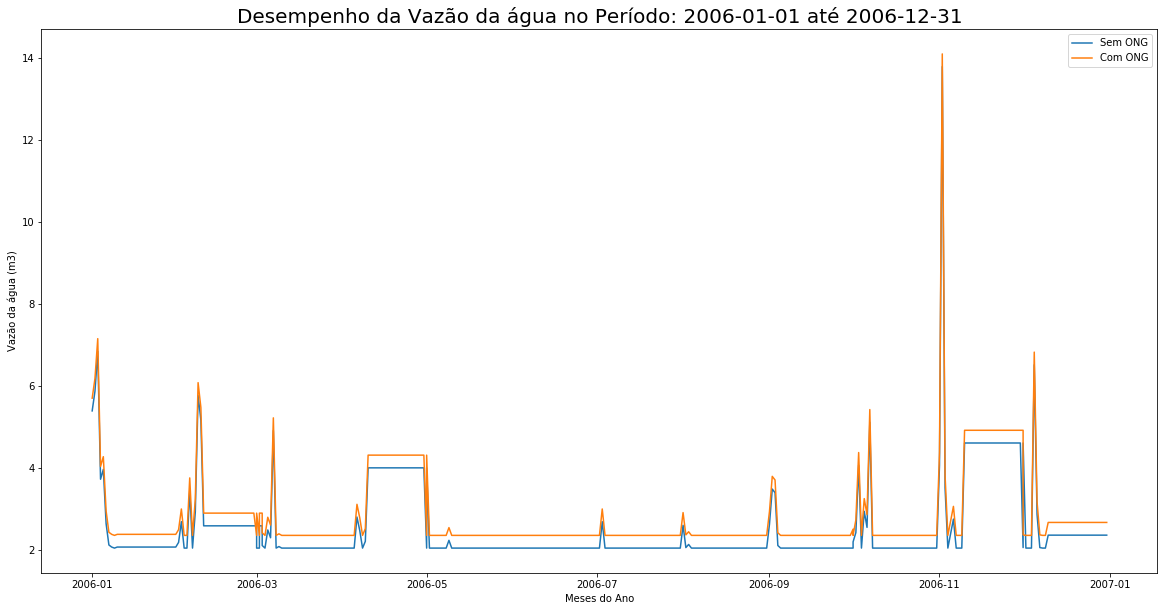

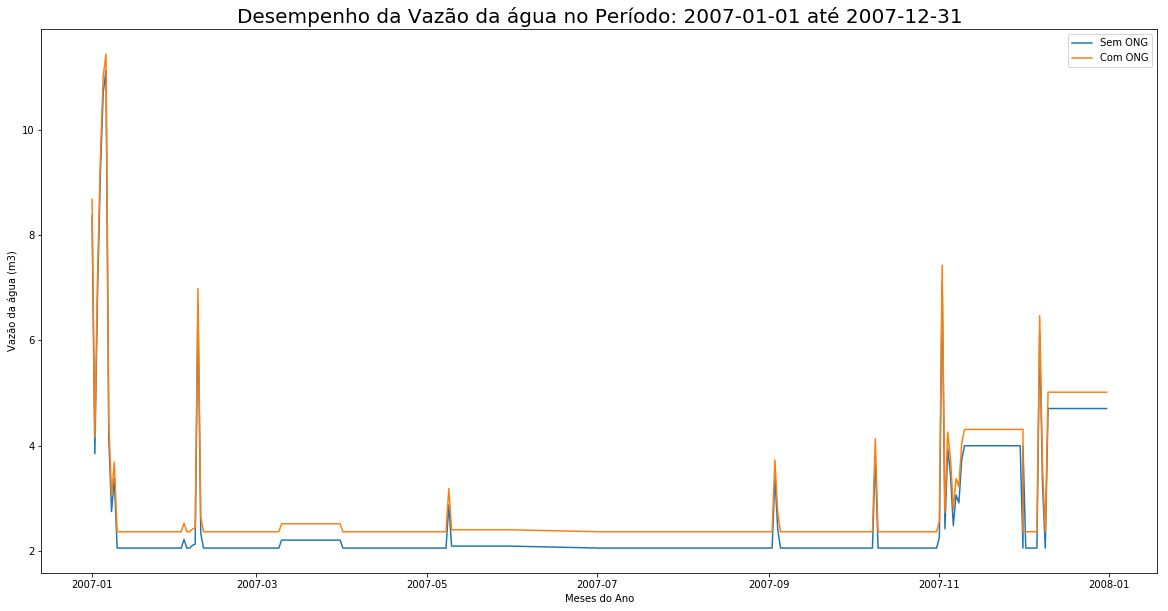

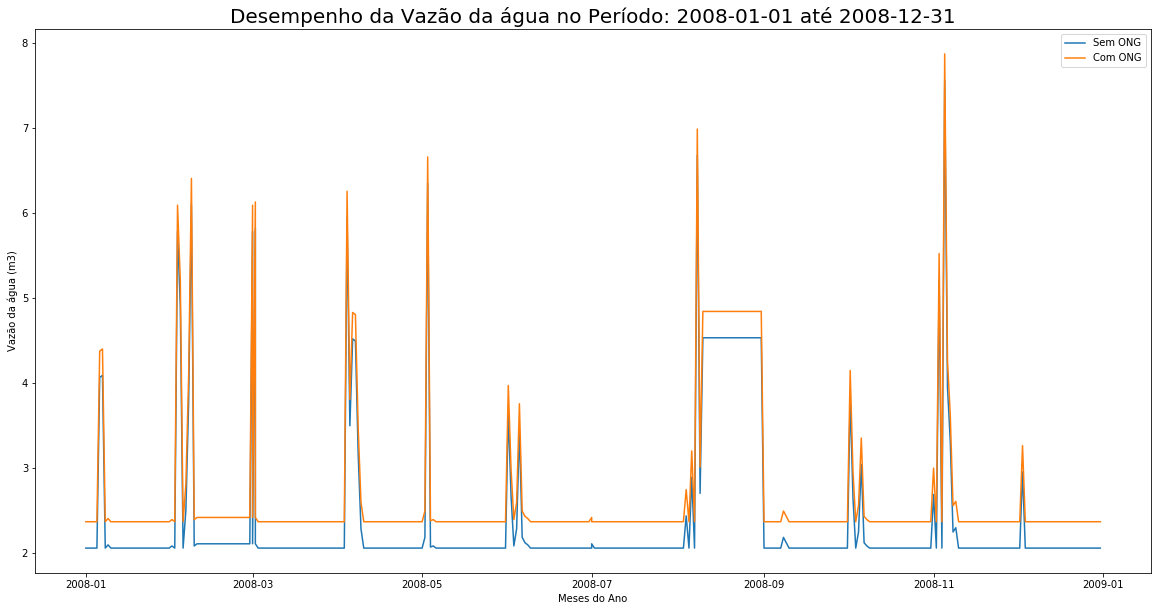

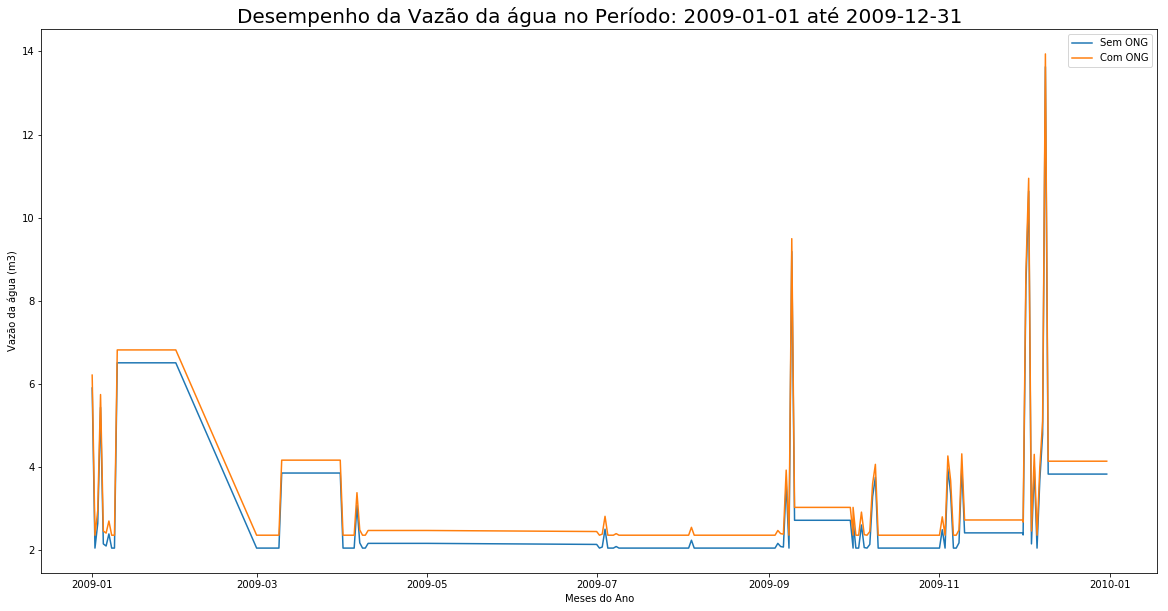

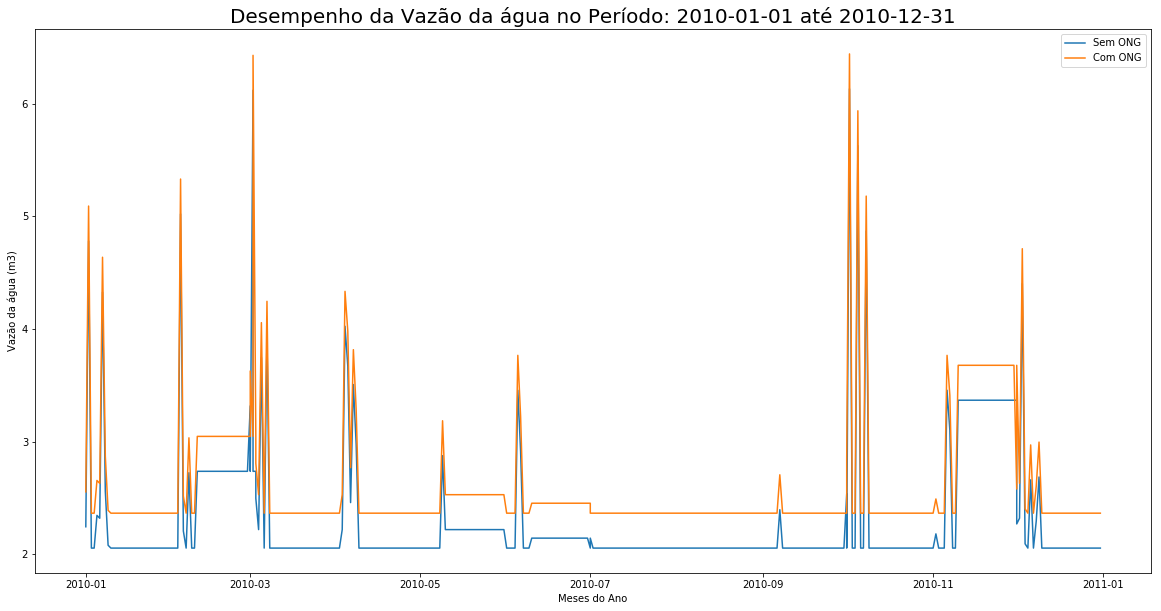

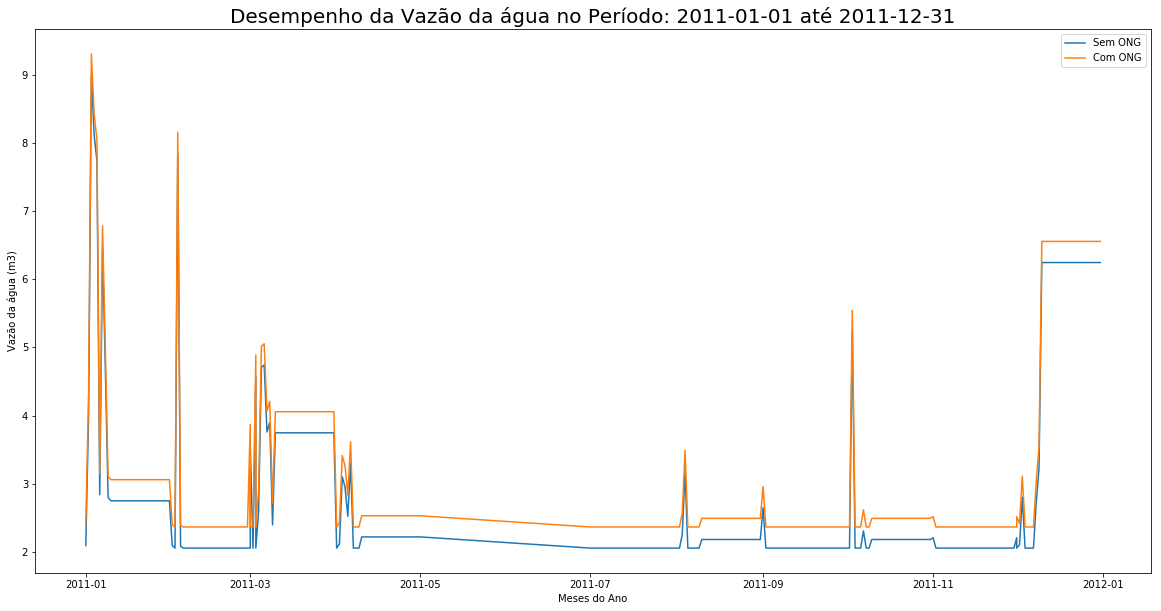

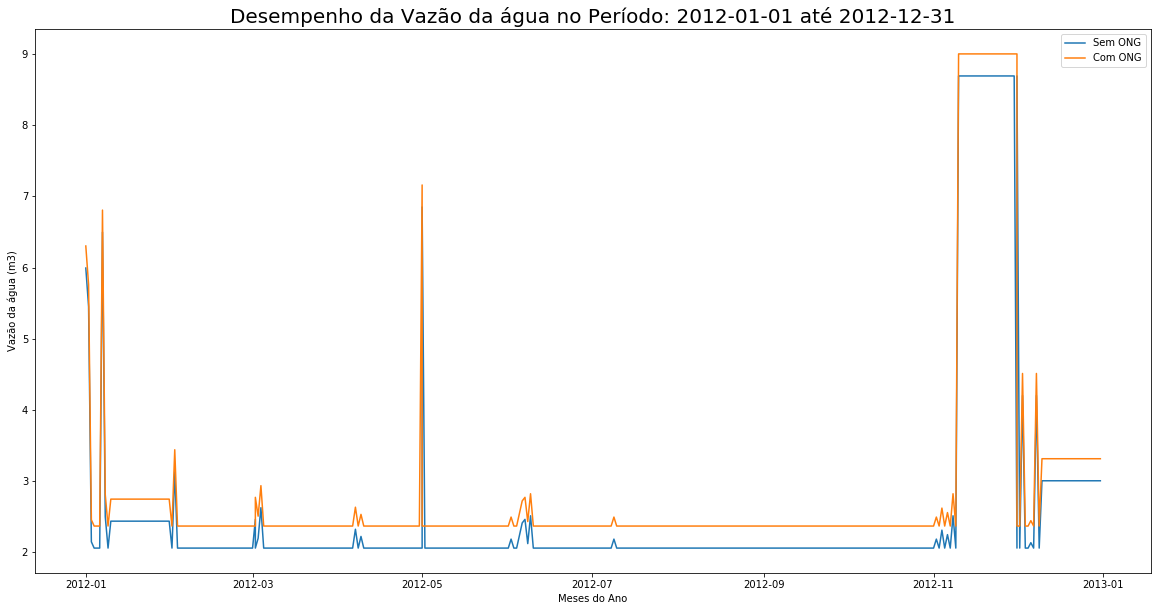

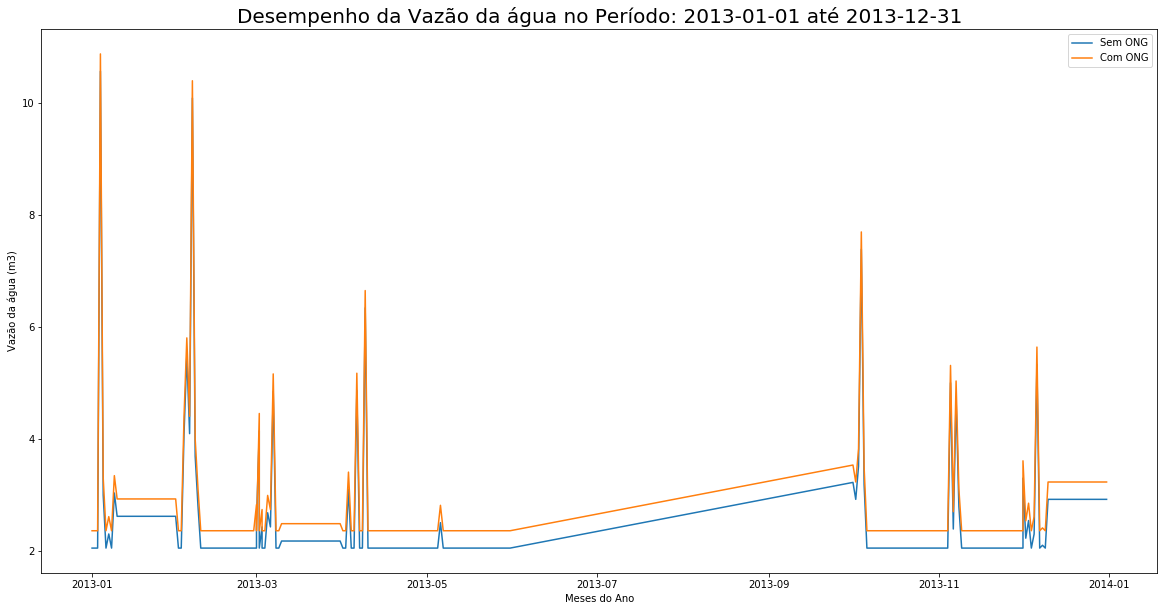

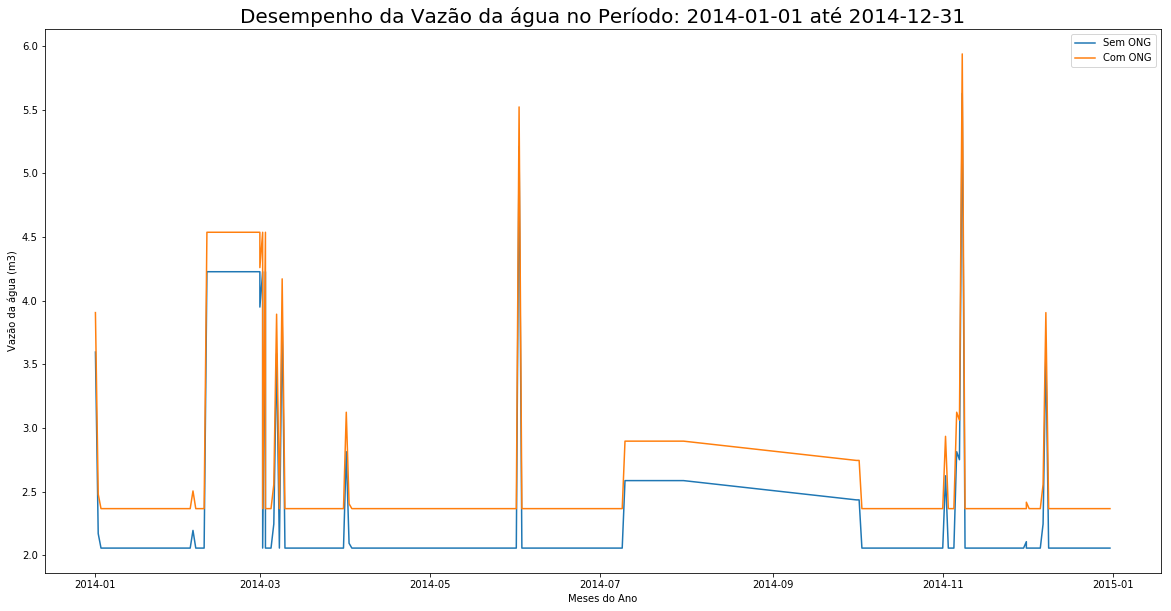

In [29]:
anos = []
totais = []
for ini, fim in zip(datasInicio, datasFim): 
    prediction0 = result0.where((col("data") >= ini) & (col("data") <= fim)) \
                     .select(col("data"), col("prediction")).orderBy("data").toPandas()
    prediction1 = result1.where((col("data") >= ini) & (col("data") <= fim)) \
                     .select(col("data"), col("prediction")).orderBy("data").toPandas()
    
    anos.append(ini)
    totais.append(((prediction1.prediction.sum() * 100) / prediction0.prediction.sum()) - 100)
    
    plt.figure(figsize=(20,10))
    plt.plot(prediction0["data"],prediction0["prediction"])
    plt.plot(prediction1["data"],prediction1["prediction"])
    plt.title('Desempenho da Vazão da água no Período: {} até {}'.format(ini,fim),size=20)
    plt.xlabel('Meses do Ano')
    plt.ylabel('Vazão da água (m3)')
    plt.legend(['Sem ONG','Com ONG'])
    #plt.ylim([2,100])
    plt.show()
    

In [30]:
anos = [x.split('-')[0] for x in anos]

(0, 20)

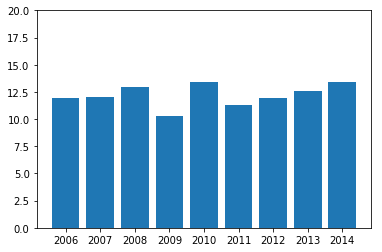

In [31]:
plt.bar(anos, totais)
plt.ylim([0,20])